## Simulations of PPE using Bayesian Optimization

In this notebook, we will perform simulations for known probabilistic distributions of a target $Y$, aiming to evaluate the effectiveness of Bayesian Optimization (BO) for inferring an optimal set of hyperparameters. To achieve that, we will assume a probabilistic distribution $Y | \pmb{\theta} \sim \pi_{Y | \pmb{\theta}}$, where $\pmb{\theta}\sim\pi_{\pmb{\theta}}$, with $\pi_{\pmb{\theta}}$ belonging to a family of distributions that is indexed by a hyperparameter vector $\pmb{\lambda}$. For a fixed value $\pmb{\lambda_{\text{true}}}$, we will obtain simulated expert probabilities for a given partition, which we will subsequently use to perform PPE using BO. The experiment will involve partitions with different number of bins, and also different number of covariates $J$, whenever the target is dependent on a set of covariates, to test how efficient the method is with more detailed partitions and also more covariate sets for which there is expert input.

We will run simulations for three different families of probabilistic models. The first is the gaussian family, where we assume that $$Y\sim \mathcal{N}(\mu, \sigma^2),$$ with different possible priors then used to define $\mu$ and $\sigma$.

The second probabilistic model family again assumes that $Y$ is drawn from a gaussian distribution, but now the mean is estimated as a linear combination of a set of covariates $x_1,...,x_n$:
$$Y\sim\mathcal{N}(b_0 + \prod_{i=1}^{n}b_i\cdot x_i, \sigma^2),$$

where $b_i \sim \mathcal{N}(\mu_i, \sigma_i)$.

The third family is that of logistic regression, where $Y$ is now binary and a function of covariates x = \{$x_1,...,x_n$\}. In probabilistic notation, we have:

$$Y\sim\mathcal{B}(p(\pmb{x}, \pmb{\theta})),$$

where $p(\pmb{x}, \pmb{\theta}) = \frac{e^{\pmb{x}^{\Tau} \pmb{\theta}}}{1 + e^{\pmb{x}^{\Tau} \pmb{\theta}}}$, with $\theta_i \sim \mathcal{N}(\mu_i, \sigma_i^2)$.


In [1]:
## imports

import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from functions import make_partition, ppe_simulation, make_plots


## Model Family 1: Gaussian distribution with no covariates

For the first model family, we will test two models, namely Model 1 and Model 2. For each, we will implement PPE with BO, considering multiple partitionings, each with a different number of bins. We will test partitionings with 2, 5, 10 and 20 bins. The way we construct the partitionings is by taking an area where $Y$ is "more likely to be into", and partition it according to the number of bins. Then, we also consider two additional partitions for the lower and upper tails of the distribution so that the total number of bins is the one desired.

In [2]:
from gaussian_models import gaussian_model_1, gaussian_model_2

In [3]:
num_bins = np.array([2, 5, 10, 20])

gaussian_partitions = [make_partition(n, 5 - 20, 5 + 20) for n in num_bins]

gaussian_partitions

[array([[-1.e+04,  5.e+00],
        [ 5.e+00,  1.e+04]]),
 array([[-1.00000000e+04, -1.50000000e+01],
        [-1.50000000e+01, -1.66666667e+00],
        [-1.66666667e+00,  1.16666667e+01],
        [ 1.16666667e+01,  2.50000000e+01],
        [ 2.50000000e+01,  1.00000000e+04]]),
 array([[-1.0e+04, -1.5e+01],
        [-1.5e+01, -1.0e+01],
        [-1.0e+01, -5.0e+00],
        [-5.0e+00,  0.0e+00],
        [ 0.0e+00,  5.0e+00],
        [ 5.0e+00,  1.0e+01],
        [ 1.0e+01,  1.5e+01],
        [ 1.5e+01,  2.0e+01],
        [ 2.0e+01,  2.5e+01],
        [ 2.5e+01,  1.0e+04]]),
 array([[-1.00000000e+04, -1.50000000e+01],
        [-1.50000000e+01, -1.27777778e+01],
        [-1.27777778e+01, -1.05555556e+01],
        [-1.05555556e+01, -8.33333333e+00],
        [-8.33333333e+00, -6.11111111e+00],
        [-6.11111111e+00, -3.88888889e+00],
        [-3.88888889e+00, -1.66666667e+00],
        [-1.66666667e+00,  5.55555556e-01],
        [ 5.55555556e-01,  2.77777778e+00],
        [ 2.77777778e+

### Model 1

For the first model, we assume that $Y\sim \mathcal{N}(\mu, \sigma^2)$, where $\mu \sim \mathcal{N}(\mu_1, \sigma_1)$ and $\sigma \sim \text{Gamma}(a, b)$. Our hyperparameter vector is then $\pmb{\lambda} = [\mu_1, \sigma_1, a, b]$. For the simulation, we assume that $\mu_1 = 5, \sigma_1 = 2, a = 2$ and $b = 3$.

In [6]:
mu_1 = 5 ; sigma_1 = 2 ; a = 2 ; b = 3

lambd_names_gaussian_1 = ["mu_1", "sigma_1", "a", "b"] ## hyperparameter names
lambd_true_vals_gaussian_1 = np.array([mu_1, sigma_1, a, b])
param_bounds_gaussian_1 = [[-10., 10.], [0.001, 10.], [0.001, 10.], [0.001, 10.]] ## bounds for each hyperparameter
alpha = None

target_type = "continuous"
target_samples = 1500
J = 1

lower_inner_gaussian_1 = 5 - 20
upper_inner_gaussian_1 = 5 + 20



simulated_expert_probs_gaussian_1 = []
best_params_gaussian_1 = []
best_probs_gaussian_1 = []
alphas_gaussian_1 = []


for i in range(num_bins.shape[0]):

    expert_probs, best_params, best_probs, alpha = ppe_simulation(model = gaussian_model_1,
                                                                  J = J,
                                                                  target_type = target_type,
                                                                  lambd_names = lambd_names_gaussian_1,
                                                                  lambd_true_vals = lambd_true_vals_gaussian_1,
                                                                  alpha = alpha,
                                                                  num_bins = num_bins[i],
                                                                  lower_inner = lower_inner_gaussian_1,
                                                                  upper_inner = upper_inner_gaussian_1,
                                                                  param_bounds = param_bounds_gaussian_1,
                                                                  target_samples = target_samples)
    
    simulated_expert_probs_gaussian_1.append(expert_probs)
    best_params_gaussian_1.append(best_params)
    best_probs_gaussian_1.append(best_probs)
    alphas_gaussian_1.append(alpha)
    

    
    


Sampling: [Y_obs, mu, sigma]
[INFO 07-01 17:20:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter mu_1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 17:20:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter sigma_1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 17:20:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 17:20:31] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 

Sampling: [Y_obs, mu, sigma]
Sampling: [Y_obs, mu, sigma]


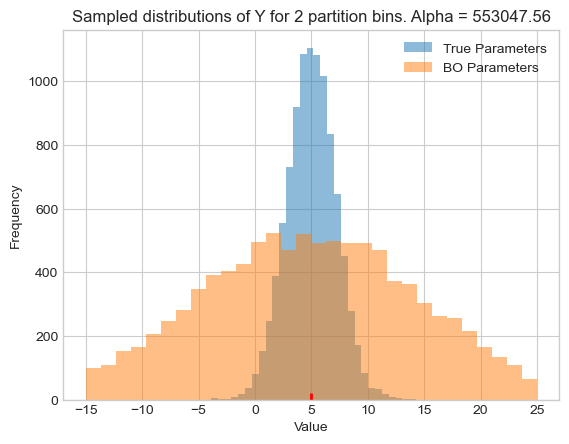

Sampling: [Y_obs, mu, sigma]
Sampling: [Y_obs, mu, sigma]


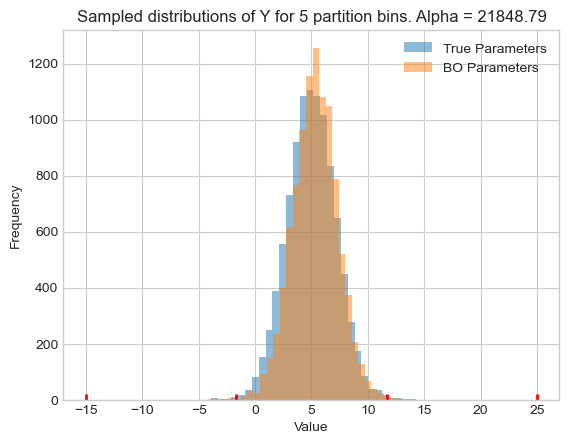

Sampling: [Y_obs, mu, sigma]
Sampling: [Y_obs, mu, sigma]


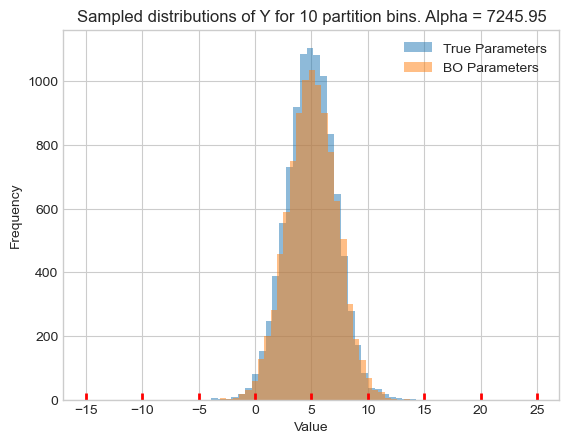

Sampling: [Y_obs, mu, sigma]
Sampling: [Y_obs, mu, sigma]


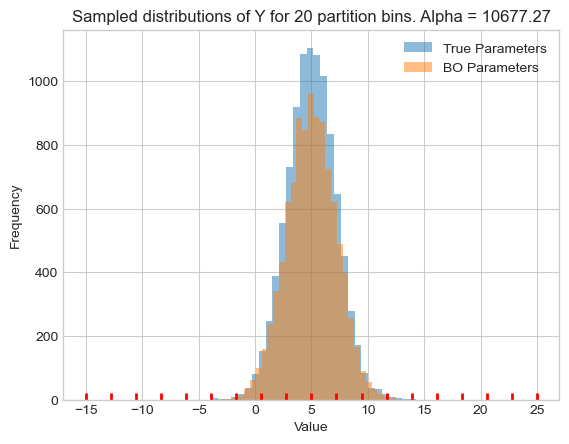

In [21]:
for i in range(len(num_bins)):

    make_plots(model = gaussian_model_1,
               lambd_names = lambd_names_gaussian_1,
               lambd_true_vals = lambd_true_vals_gaussian_1,
               best_params = best_params_gaussian_1[i],
               alpha = alphas_gaussian_1[i],
               J = J,
               num_bins = num_bins[i],
               partitions=gaussian_partitions[i],
               lower_inner = lower_inner_gaussian_1,
               upper_inner = upper_inner_gaussian_1)
    

In [22]:
lambd_true_vals_gaussian_1

array([5, 2, 2, 3])

In [23]:
best_params_gaussian_1

[{'mu_1': 4.689783355737429,
  'sigma_1': 10.0,
  'a': 8.31236286045022,
  'b': 4.799400850504542,
  'alpha': 70.0},
 {'mu_1': 5.347967705773296,
  'sigma_1': 1.379590403280051,
  'a': 10.0,
  'b': 7.281060184249},
 {'mu_1': 5.068162443107369,
  'sigma_1': 2.0169706543732153,
  'a': 4.340922493791863,
  'b': 6.077495910917584},
 {'mu_1': 4.996927455214761,
  'sigma_1': 2.144617996985847,
  'a': 3.641811996152354,
  'b': 9.390508901295576}]

### Model 2

Similar to Model 1, we assume for Model 2 that $Y\sim \mathcal{N}(\mu, \sigma^2)$, where $\mu \sim \mathcal{N}(\mu_1, \sigma_1)$ and $\sigma \sim \text{Gamma}(a, b)$. The difference is that now we also assume hyperpriors for the parameters of $\mu$'s prior, specifically $\mu_1\sim\mathcal{N}(\mu_m, \sigma_m)$ and $\sigma_1 \sim \mathcal{LN}(\mu_s, \sigma_s)$, where $\mathcal{LN}$ is the log-gaussian distribution. This implies a hyperparameter vector $\pmb{\lambda} = [\mu_m, \sigma_m, \mu_s, \sigma_s, a, b]$. For the simulation, we assume that $\mu_m = 5, \sigma_m = 1, \mu_s = 0.4, \sigma_m = 4, a = 2$ and $b = 3$.

In [24]:
mu_m = 5 ; sigma_m = 1 ; mu_s = 0.4 ; sigma_s = 4 ; a = 2 ; b = 3

lambd_names_gaussian_2 = ["mu_m", "sigma_m", "mu_s", "sigma_s", "a", "b"] ## hyperparameter names
lambd_true_vals_gaussian_2 = np.array([mu_m, sigma_m, mu_s, sigma_s, a, b])
param_bounds_gaussian_2 = [[-10., 10.], [0.001, 10.], [-10., 10.], [0.001, 10.], [0.001, 10.], [0.001, 10.]] ## bounds for each hyperparameter
alpha = None

target_type = "continuous"
target_samples = 1500
J = 1

lower_inner_gaussian_2 = 5 - 20
upper_inner_gaussian_2 = 5 + 20



simulated_expert_probs_gaussian_2 = []
best_params_gaussian_2 = []
best_probs_gaussian_2 = []
alphas_gaussian_2 = []


for i in range(num_bins.shape[0]):

    expert_probs, best_params, best_probs, alpha = ppe_simulation(model = gaussian_model_2,
                                                                  J = J,
                                                                  target_type = target_type,
                                                                  lambd_names = lambd_names_gaussian_2,
                                                                  lambd_true_vals = lambd_true_vals_gaussian_2,
                                                                  alpha = alpha,
                                                                  num_bins = num_bins[i],
                                                                  lower_inner = lower_inner_gaussian_2,
                                                                  upper_inner = upper_inner_gaussian_2,
                                                                  param_bounds = param_bounds_gaussian_2,
                                                                  target_samples = target_samples)
    
    simulated_expert_probs_gaussian_2.append(expert_probs)
    best_params_gaussian_2.append(best_params)
    best_probs_gaussian_2.append(best_probs)
    alphas_gaussian_2.append(alpha)
    

    
    

Sampling: [Y_obs, mu, mu_hyp, sigma, sigma_hyp]
[INFO 07-01 18:28:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter mu_m. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 18:28:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter sigma_m. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 18:28:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter mu_s. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-01 18:28:20] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter sigma_s. If that is not the expected value type, you can explicitly specify 'value_type'

: 

In [ ]:
for i in range(len(num_bins)):

    make_plots(model = gaussian_model_2,
               lambd_names = lambd_names_gaussian_2,
               lambd_true_vals = lambd_true_vals_gaussian_2,
               best_params = best_params_gaussian_2[i],
               alpha = alphas_gaussian_2[i],
               J = J,
               num_bins = num_bins[i],
               partitions=gaussian_partitions[i],
               lower_inner = lower_inner_gaussian_2,
               upper_inner = upper_inner_gaussian_2)